# Simulation
> 

- toc:true
- branch: master
- badges: true
- comments: false
- author: 최서연
- categories: [논문연구]

---

#### 5.1.1 SPECTRAL NETWORK

$$g_{\theta} \star x = U g_{\theta}(\Lambda) U^{\top}x$$

$x$는 실수($n \times 1$ or $1 \times n$), $g_{\theta}$는 $\theta$의 대각행렬, $\theta$는 실수($n \times 1$ or $1 \times n$)

$U$가 정규화된 그래프 라플라시안의 고유벡터 행렬일떄($L = I_N - D^{-\frac{1}{2}}AD^{-\frac{1}{2}} = U\Lambda U^{\top}$), 고유값 $\Lambda$의 대각 행렬을 가진다.

Bruna가 재안한 operation에서 Henaff 는 평활 계수를 가진 파라미터로 차원적이며 집약적인 spectral filters 를 만듦

---

Henaff

$W$가 $n \times n$  대칭 행렬

$L = I_N - D^{-\frac{1}{2}}WD^{-\frac{1}{2}}$

$D_{ij} = \sum_{ij}W_{ij}$

$U = (u_1, \dots, u_N)$

$X = \mathbb{R}^N$

$x *_Gg = U^{\top} (U_x \odot U)g)$

$\odot$: a point-wise product

$w_g = (w_1, \dots, w_N)$

$x *_Gg := U^{\top} (diag(w_g)U_x)$

$\big{|} \frac{\partial^k \hat{x} (\xi)}{\partial \xi^k} \big{|} \le \int |u|^k |x(u)|\: \mathrm{d}x $

$\hat{x} (\xi)$ is the Fourier tranform of $x$

$w_g = \mathcal{K}\tilde{w}_g$

$\mathcal{K}$ is a smoothing kernal, $\mathcal{K} \in \mathbb{R}^{N \times N_0}$

forward, backward 가능

unsupervised graph estimation 
- $d(i,j) = \|X_i - X_j \|^2
- $w(i,j) = exp^{\frac{d(i,j)}{\sigma^2}}$$

supervised graph estimation
- a fully-connected network
- $d_{sup}(i,j) = \| W_{1,i} - W_{1,j} \|^2$

---

#### 5.1.2 CHEBNET

$$g_{\theta} \star x \approx  \sum^{K}_{k=0}\theta_k T_k (\tilde{L})x$$

 The Chebyshev polynomials 체비셰프 다항식

$\tilde{L} = \cfrac{2}{\lambda_{max}} L - I_N$

$\lambda_{max}$는 라플라시안 고유값들 중 가장 큰 값

$T_k (x) = 2xT_{k-1}(x) - T_{k-2} (x)$

$T_0 (x) = 1$, $T_1(x) = x$

---

## imports

In [4]:
import rpy2
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

In [5]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML

In [6]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [7]:
from plotly.subplots import make_subplots

## EbayesThresh

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R
library(EbayesThresh)
set.seed(1)
x <- rnorm(1000) + sample(c( runif(25,-7,7), rep(0,975)))
#plot(x,type='l')
#mu <- EbayesThresh::ebayesthresh(x,sdev=2)
#lines(mu,col=2,lty=2,lwd=2)

### R + python

`-` R환경에 있던 x를 가지고 오기

In [10]:
%R -o x 

`-` R환경에 있는 ebayesthresh 함수를 가지고 오기

In [11]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [12]:
xhat = np.array(ebayesthresh(FloatVector(x)))

In [15]:
#plt.plot(x)
#plt.plot(xhat)

## 시도 1

In [11]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x
_y = _y1 + x # x is epsilon

In [12]:
df1=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [13]:
w=np.zeros((1000,1000))

In [14]:
for i in range(1000):
    for j in range(1000):
        if i==j :
            w[i,j] = 0
        elif np.abs(i-j) <= 1 : 
            w[i,j] = 1

In [15]:
class SIMUL:
    def __init__(self,df):
        self.df = df
        self.y = df.y.to_numpy()
        self.y1 = df.y1.to_numpy()
        self.x = df.x.to_numpy()
        self.n = len(self.y)
        self.W = w
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)      
    def fit(self,sd=5): # fit with ebayesthresh
        self._eigen()
        self.ybar = self.Psi.T @ self.y # fbar := graph fourier transform of f
        self.power = self.ybar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.ybar**2),sd=sd))
        self.ybar_threshed = np.where(self.power_threshed>0,self.ybar,0)
        self.yhat = self.Psi@self.ybar_threshed
        self.df = self.df.assign(yHat = self.yhat)
        self.df = self.df.assign(Residual = self.df.y- self.df.yHat)
        self.differ=(np.abs(self.y-self.yhat)-np.min(np.abs(self.y-self.yhat)))/(np.max(np.abs(self.y-self.yhat))-np.min(np.abs(self.y-self.yhat))) #color 표현은 위핸 표준화
        self.df = self.df.assign(differ = self.differ)
        #with plt.style.context('seaborn-dark'):
            #plt.figure(figsize=(16,10))
            #plt.scatter(self.x,self.y,c=self.differ3,cmap='Purples',s=50)
            #plt.plot(self.x,self.yhat, 'k--')
    def vis(self,ref=60):
        fig = go.Figure()
        fig.add_scatter(x=self.x,y=self.y,mode="markers",marker=dict(size=2, color="#9fc5e8"),name='y',opacity=0.7)
        fig.add_scatter(x=self.x,y=self.yhat,mode="markers",marker=dict(size=2, color="#000000"),name='yhat',opacity=0.7)
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#0000FF',name='underline'))
        fig.update_layout(width=1000,height=1000,autosize=False,margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def sub(self):
        fig, axs = plt.subplots(2,2,figsize=(16,10))

        axs[0,0].plot(self.power)
        axs[0,0].plot(self.power_threshed)
        axs[0,0].set_title('power_threshed')

        axs[0,1].plot(self.power[1:])
        axs[0,1].plot(self.power_threshed[1:])
        axs[0,1].set_title('power_threshed 1:')

        axs[1,0].plot(self.power[2:])
        axs[1,0].plot(self.power_threshed[2:])
        axs[1,0].set_title('power_threshed 2:')

        axs[1,1].plot((self.df.Residual)**2)
        axs[1,1].set_title('Residual square')

        plt.tight_layout()
        plt.show()
    def subvis(self,ref=60):
        fig = make_subplots(rows=2, cols=2, subplot_titles=("y", "yhat", "Residual Square", "Graph"))
                            
        fig.add_scatter(x=self.x,y=self.y, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='y',opacity=0.7,row=1,col=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=1,col=1)
        
        fig.add_scatter(x=self.x,y=self.yhat, mode="markers",marker=dict(size=3, color="#999999"),name='yhat',opacity=0.7,row=1,col=2)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=1,col=2)
        
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=1)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=2,col=1)
        
        fig.add_scatter(x=self.x,y=self.y, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='y',opacity=0.7,row=2,col=2)        
        fig.add_scatter(x=self.x,y=self.yhat, mode="markers",marker=dict(size=3, color="#999999"),name='yhat',opacity=0.7,row=2,col=2)        
        fig.add_scatter(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=2)
        fig.add_trace(go.Scatter(x=self.x,y=self.y1,mode='lines',line_color='#000000',name='underline'),row=2,col=2)
        
        fig.update_xaxes(range=[0, 2], row=1, col=1)
        fig.update_yaxes(range=[-5, 15], row=1, col=1)
        
        fig.update_xaxes(range=[0, 2], row=1, col=2)
        fig.update_yaxes(range=[-5, 15], row=1, col=2)
        
        fig.update_xaxes(range=[0, 2], row=2, col=1)
        fig.update_yaxes(range=[-5, 15], row=2, col=1)
        
        fig.update_xaxes(range=[0, 2], row=2, col=2)
        fig.update_yaxes(range=[-5, 15], row=2, col=2)
        
        fig.update_layout(width=1000,height=1000,autosize=False,showlegend=False,title_text="The result")
        
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [16]:
class SIMUL2(SIMUL):
    def fit2(self,sd=5,ref=60,cuts=0,cutf=995):
        self.fit()
        with plt.style.context('seaborn-dark'):
            plt.figure(figsize=(16,10))
            plt.scatter(self.x,self.y,c=self.differ3,cmap='Purples',s=50)
            plt.scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50)
            plt.plot(self.x,self.y1,'b--')
            plt.plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k--')
    def fit3(self,sd=5,ref=30,ymin=-5,ymax=20,cuts=0,cutf=995):
        self.fit()
        with plt.style.context('seaborn-dark'):
            fig, axs = plt.subplots(2,2,figsize=(16,10))

            axs[0,0].scatter(self.x,self.y,c=self.differ,cmap='Purples',s=50)
            axs[0,0].set_title('y')
            axs[0,0].set_ylim([ymin,ymax])
            

            axs[0,1].plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k')
            axs[0,1].plot(self.x[cuts:cutf],self.y1[cuts:cutf], 'b',alpha=0.5)
            axs[0,1].set_title('yhat')
            axs[0,1].set_ylim([ymin,ymax])

            axs[1,0].scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50,marker='*')
            axs[1,0].plot(self.x[cuts:cutf],self.y1[cuts:cutf], 'b',alpha=0.5)
            axs[1,0].set_title('Residual square')
            axs[1,0].set_ylim([ymin,ymax])

            axs[1,1].scatter(self.x,self.y,c=self.differ,cmap='Purples',s=50)
            axs[1,1].plot(self.x[cuts:cutf],self.yhat[cuts:cutf], 'k')
            axs[1,1].scatter(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],color='red',s=50,marker='*')
            axs[1,1].set_title('Graph')
            axs[1,1].set_ylim([ymin,ymax])

            plt.tight_layout()
            plt.show()

In [17]:
_simul = SIMUL2(df1)

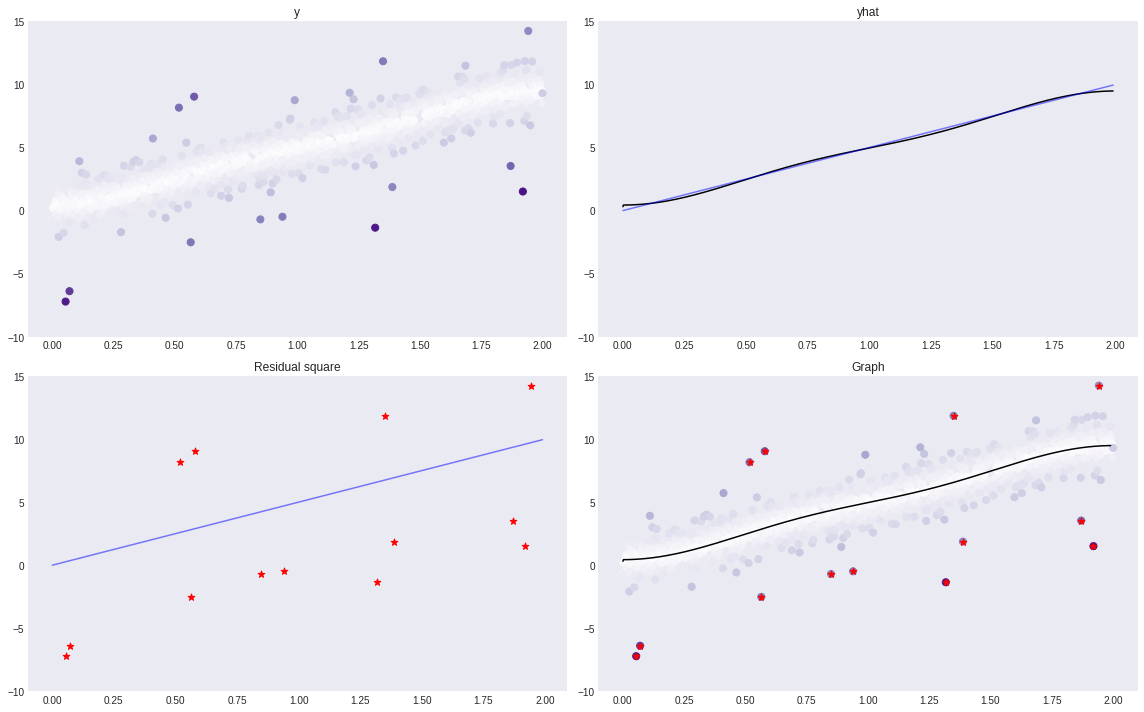

In [18]:
_simul.fit3(sd=5,ref=20,ymin=-10,ymax=15)

In [19]:
#_simul.vis()

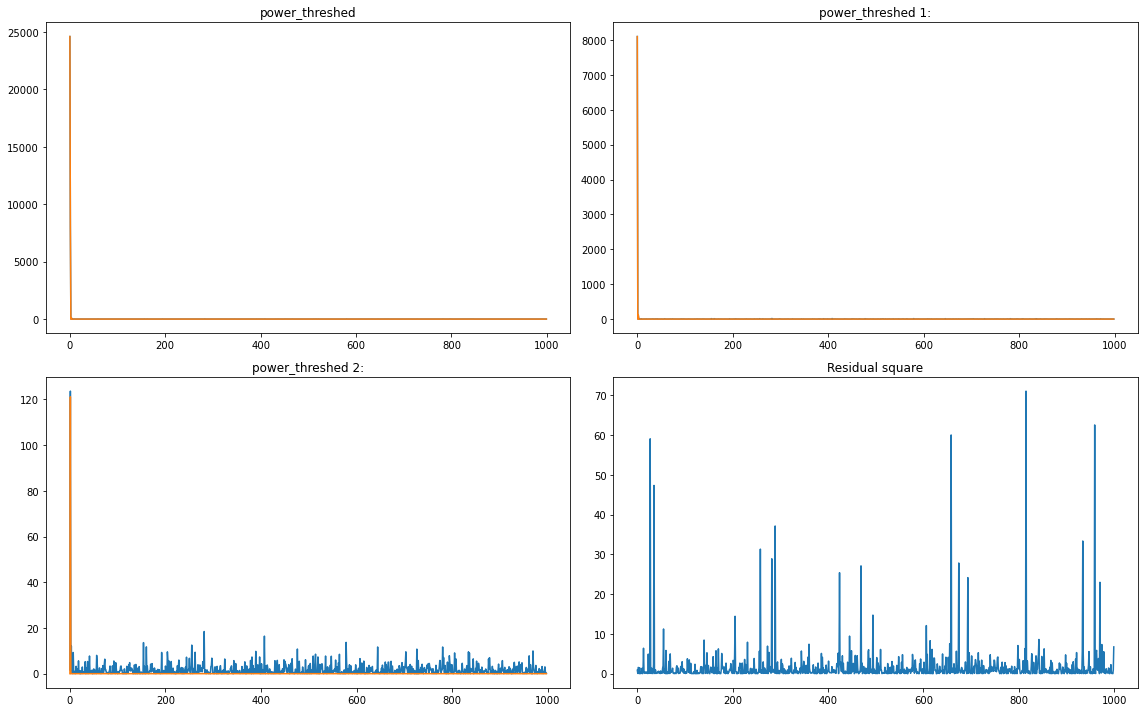

In [20]:
_simul.sub()

In [21]:
#_simul.subvis()

## 시도 2

In [84]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**2
_y = _y1 + x # x is epsilon

In [85]:
df2=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [86]:
_simul = SIMUL2(df2)

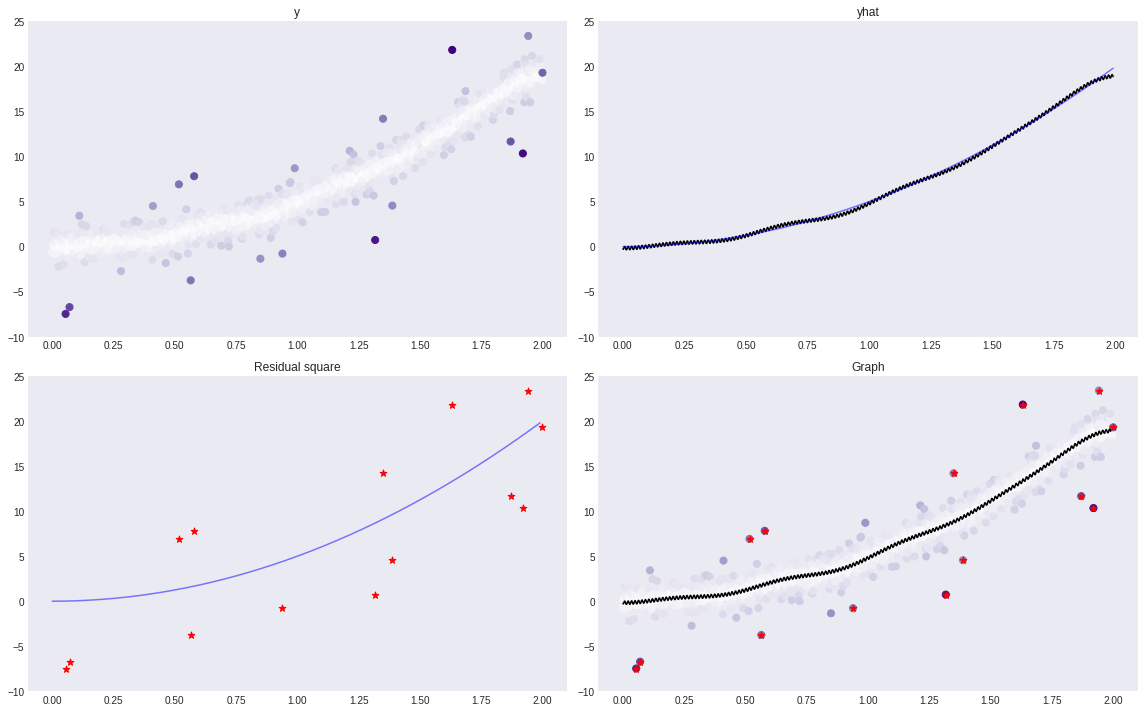

In [90]:
_simul.fit3(sd=6,ref=20,ymin=-10,ymax=25)

In [26]:
#_simul.vis()

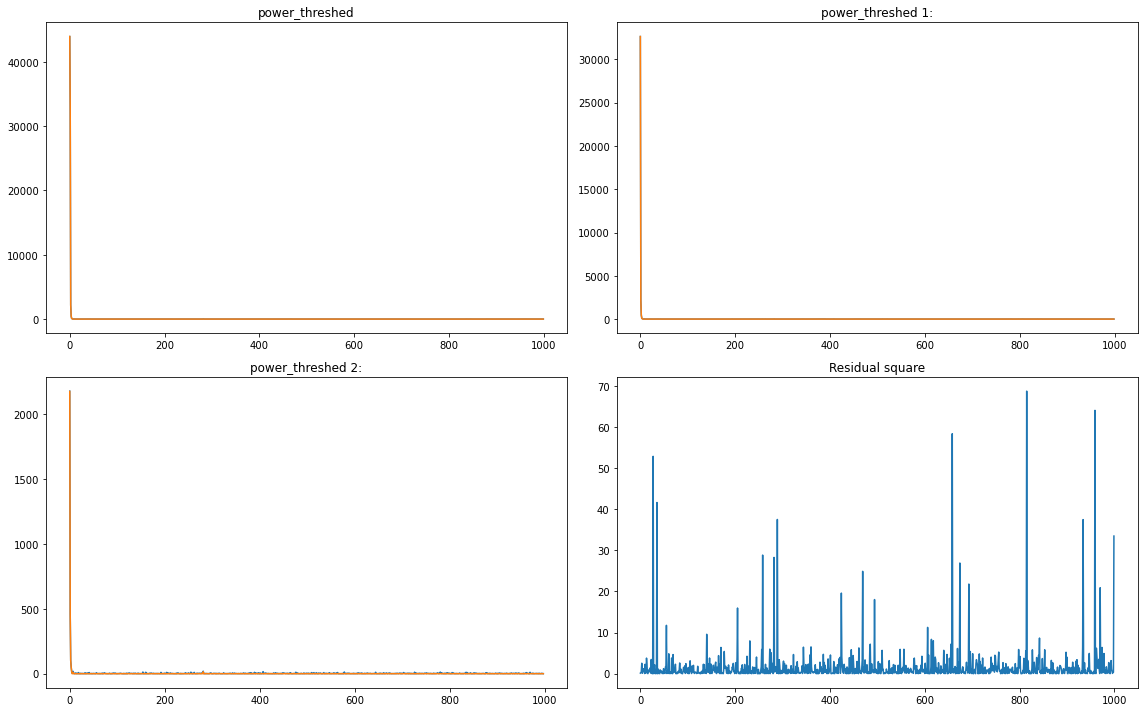

In [27]:
_simul.sub()

## 시도 3

In [28]:
_x = np.linspace(0,2,1000)
_y1 = 5*_x**3 
_y = _y1 + x # x is epsilon

In [29]:
df3=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [30]:
_simul = SIMUL2(df3)

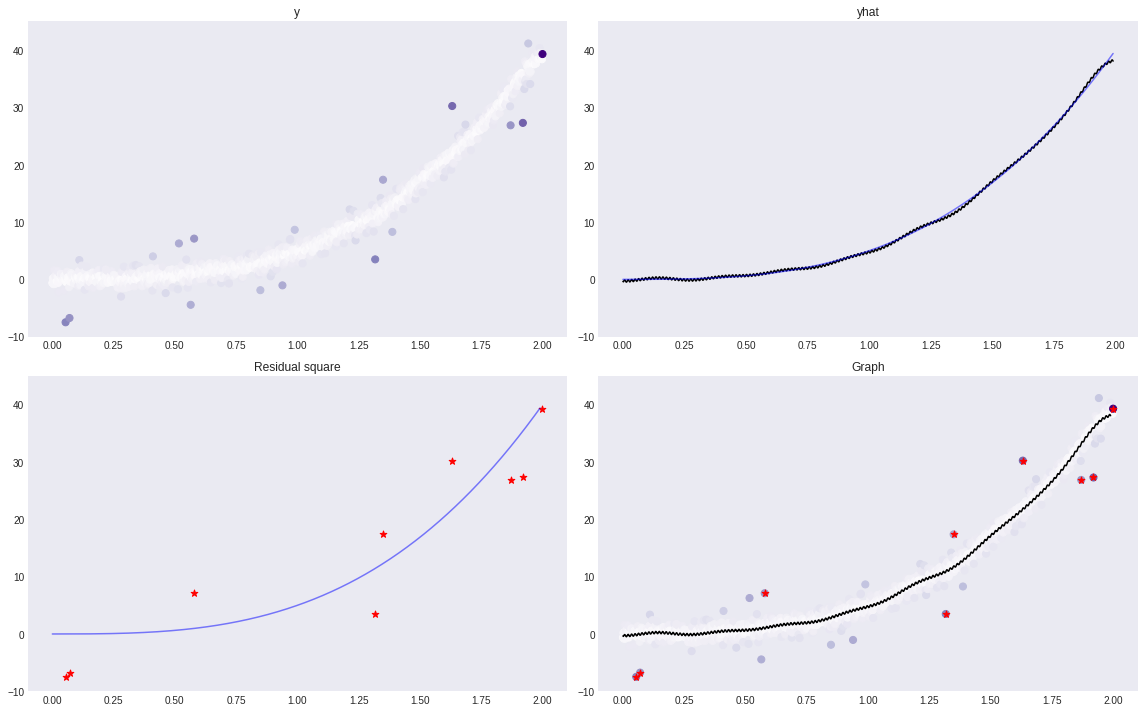

In [31]:
_simul.fit3(ymin=-10,ymax=45)

In [32]:
#_simul.vis()

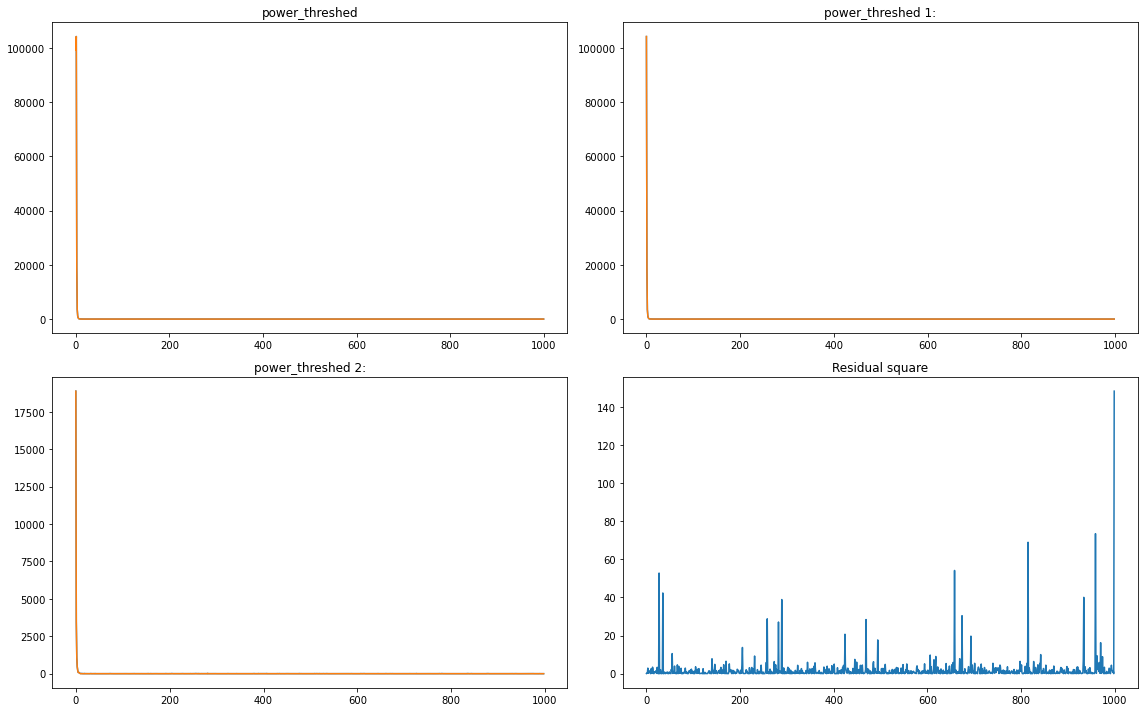

In [33]:
_simul.sub()

## 시도 4

In [34]:
_x = np.linspace(0,2,1000)
_y1 = -2+ 3*np.cos(_x) + 1*np.cos(2*_x) + 5*np.cos(5*_x)
_y = _y1 + x

In [35]:
# _x = np.linspace(0,2,1000)
# _y1 = 5*np.sin(_x) 
# _y = _y1 + x # x is epsilon

In [36]:
df4=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [37]:
_simul = SIMUL2(df4)

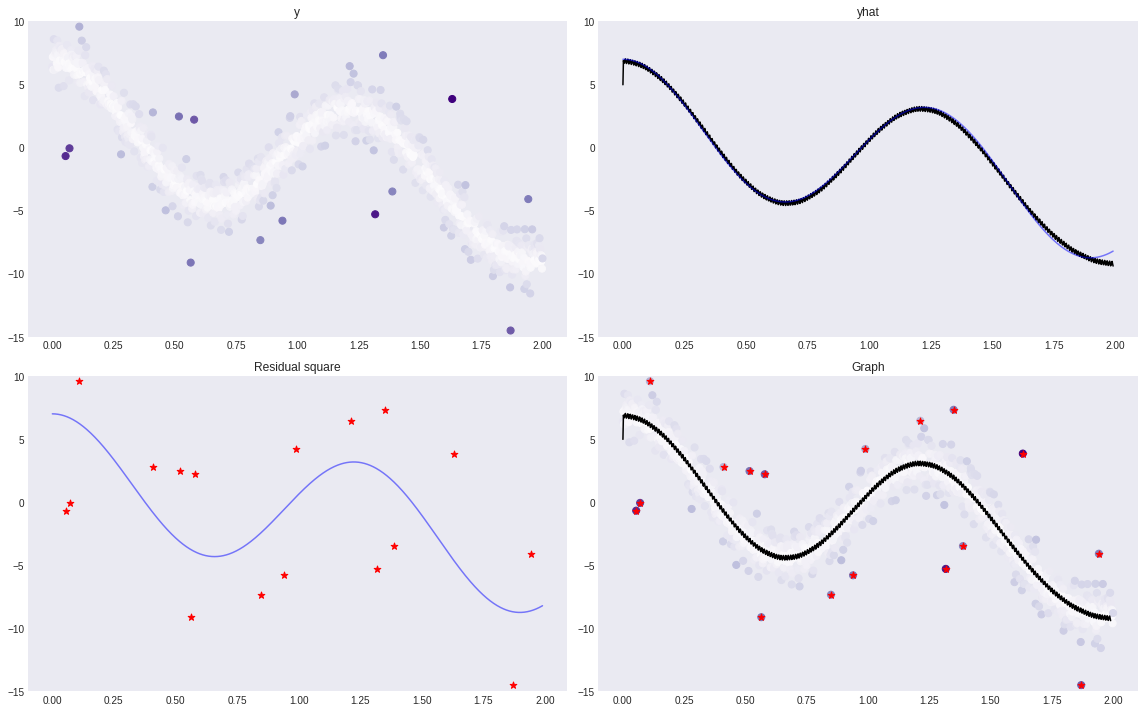

In [38]:
_simul.fit3(ref=10,ymin=-15,ymax=10)

In [39]:
#_simul.vis()

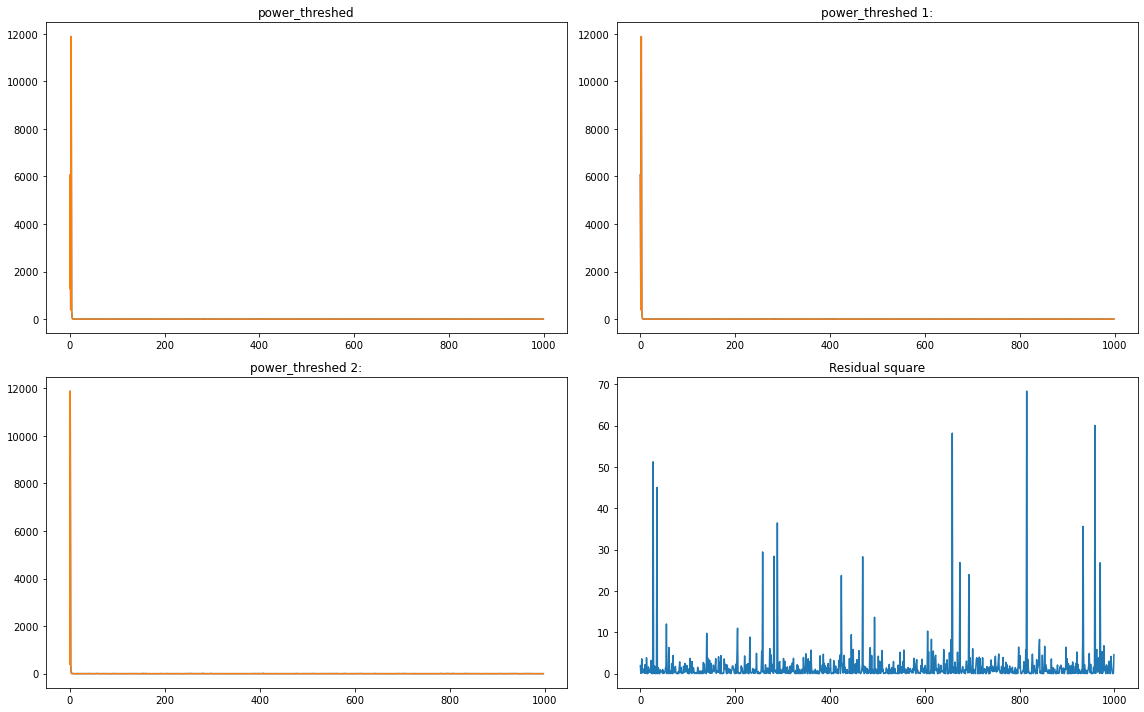

In [40]:
_simul.sub()

## 시도 5

In [41]:
# _x = np.linspace(0,2,1000)
# _y1 =  3*np.cos(_x) + 1*np.cos(_x**2) + 0.5*np.cos(5*_x) 
# _y = _y1 + x # x is epsilon

In [42]:
_x = np.linspace(0,2,1000)
_y1 =  3*np.sin(_x) + 1*np.sin(_x**2) + 5*np.sin(5*_x) 
_y = _y1 + x # x is epsilon

In [43]:
df5=pd.DataFrame({'x':_x, 'y':_y, 'y1':_y1})

In [44]:
_simul = SIMUL2(df5)

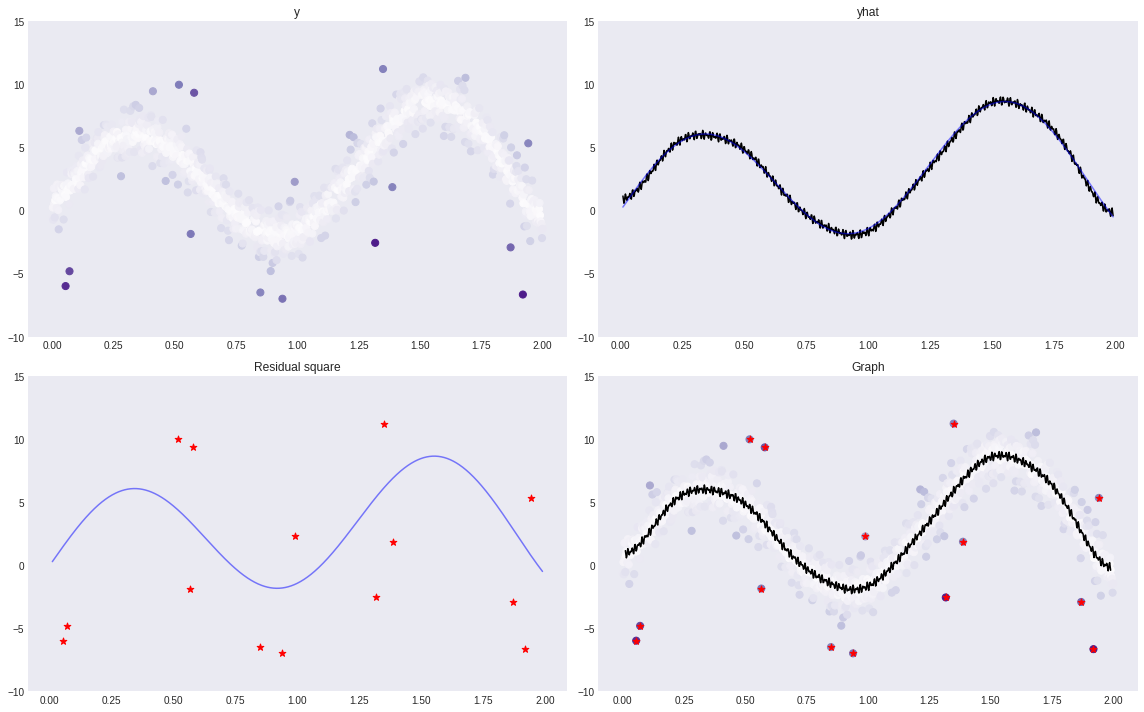

In [45]:
_simul.fit3(ref=15,ymin=-10,ymax=15,cuts=5)

In [46]:
#_simul.vis()

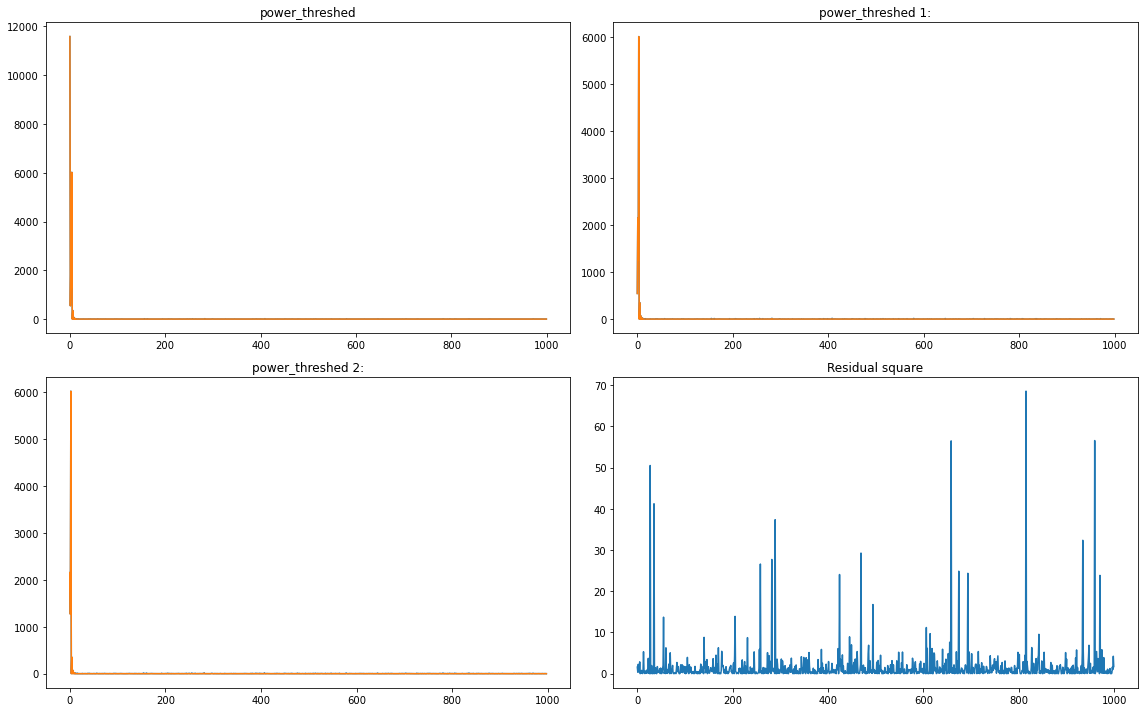

In [47]:
_simul.sub()

---

## 3D 시도 1

In [91]:
### Example 2
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

```python
# 1. 
p=plt.figure(figsize=(12,4), dpi=200)  # Make figure object 

# 2. 
ax=p.add_subplot(1,1,1, projection='3d')
ax.grid(False)
ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
top = f
bottom = np.zeros_like(top)
width=depth=0.05
#ax.bar3d(vx, vy, bottom, width, depth, top, shade=False)
ax.scatter3D(vx,vy,f,zdir='z',s=10,marker='.')
ax.scatter3D(vx,vy,f1,zdir='z',s=10,marker='.')
ax.bar3d(vx, vy, bottom, width, depth, 0, color='Black',shade=False)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.set_zlim(-10,10)
```

In [92]:
df = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f, 'f1' : f1})

In [204]:
class SIMUL:
    def __init__(self,df):
        self.df = df 
        self.f = df.f.to_numpy()
        self.f1 = df.f1.to_numpy()
        self.x = df.x.to_numpy()
        self.y = df.y.to_numpy()
        self.n = len(self.f)
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.x, self.y],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n):
                self.D[i,j]=np.linalg.norm(locations[i]-locations[j])
        self.D = self.D + self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D < kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)
    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)       
    def fit(self,sd=5,ref=60): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2),sd=sd))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(fHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.f- self.df.fHat)
        self.dif=(np.abs(self.f-self.fhat)-np.min(np.abs(self.f-self.fhat)))/(np.max(np.abs(self.f-self.fhat))-np.min(np.abs(self.f-self.fhat)))
        self.df = self.df.assign(dif = self.dif)
        self.bottom = np.zeros_like(self.f)
        self.width=0.05
        self.depth=0.05
        
        fig, axs = plt.subplots(2,2,figsize=(16,16),subplot_kw={"projection":"3d"})
        axs[0,0].grid(False)
        axs[0,0].scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
        axs[0,0].plot3D(self.x,self.y,[0]*1000,'black')
        axs[0,0].set_xlim(-3,3)
        axs[0,0].set_ylim(-3,3)
        axs[0,0].set_zlim(-10,10)
        axs[0,0].view_init(elev=20., azim=40)
        
        axs[0,1].grid(False)
        axs[0,1].scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
        axs[0,1].plot3D(self.x,self.y,self.f1,'blue')
        axs[0,1].plot3D(self.x,self.y,[0]*1000,'black')
        axs[0,1].set_xlim(-3,3)
        axs[0,1].set_ylim(-3,3)
        axs[0,1].set_zlim(-10,10)
        axs[0,1].view_init(elev=20., azim=40)
        
        axs[1,0].grid(False)
        axs[1,0].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
        axs[1,0].plot3D(self.x,self.y,self.f1,'blue')
        axs[1,0].plot3D(self.x,self.y,[0]*1000,'black')
        axs[1,0].set_xlim(-3,3)
        axs[1,0].set_ylim(-3,3)
        axs[1,0].set_zlim(-10,10)
        axs[1,0].view_init(elev=20., azim=40)
        
        axs[1,1].grid(False)
        axs[1,1].scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
        axs[1,1].scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
        axs[1,1].scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
        axs[1,1].plot3D(self.x,self.y,self.f1,'black')
        axs[1,1].plot3D(self.x,self.y,[0]*1000,'black')
        axs[1,1].set_xlim(-3,3)
        axs[1,1].set_ylim(-3,3)
        axs[1,1].set_zlim(-10,10)
        axs[1,1].view_init(elev=20., azim=40)
        
        plt.tight_layout()
        plt.show()
        
        # p = plt.figure(figsize=(16,16))
        # ax = p.add_subplot(1,1,1, projection='3d')
        # ax.grid(False)
        # ax.ticklabel_format(style='sci', axis='x',scilimits=(0,0))
        # ax.ticklabel_format(style='sci', axis='y',scilimits=(0,0))
        # ax.ticklabel_format(style='sci', axis='z',scilimits=(0,0))
        # ax.scatter3D(self.x,self.y,self.f,c=self.dif,cmap='winter',zdir='z',s=50,marker='.',alpha=0.2)
        # ax.scatter3D(self.x,self.y,self.fhat,color='black',zdir='z',s=50,marker='.',alpha=0.2)
        # #ax.plot3D(self.x,self.y,self.fhat,'black')
        # ax.scatter3D(self.df.query('Residual**2>@ref')['x'],self.df.query('Residual**2>@ref')['y'],self.df.query('Residual**2>@ref')['f'],color='red',zdir='z',s=100,marker='.',alpha=1)
        # ax.plot3D(self.x,self.y,self.f1,'black')
        # ax.plot3D(self.x,self.y,[0]*1000,'black')
        # ax.set_xlim(-3,3)
        # ax.set_ylim(-3,3)
        # ax.set_zlim(-10,10)
    def vis(self,ref=60):
        fig = go.Figure()
        fig.add_scatter3d(x=self.x,y=self.y,z=self.f, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='f',opacity=0.2)
        fig.add_scatter3d(x=self.x,y=self.y,z=self.fhat, mode="markers",marker=dict(size=3, color="#999999"),name='fhat',opacity=0.2)
        #fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.fhat,mode='lines',line_color='#000000'))
        fig.add_scatter3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['f'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'))
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'))
        fig.update_layout(width=1000,height=1000,autosize=False,margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def sub(self):
        fig, axs = plt.subplots(2,2,figsize=(16,10))

        axs[0,0].plot(_simul.power)
        axs[0,0].plot(_simul.power_threshed)
        axs[0,0].set_title('power_threshed')

        axs[0,1].plot(_simul.power[1:])
        axs[0,1].plot(_simul.power_threshed[1:])
        axs[0,1].set_title('power_threshed 1:')

        axs[1,0].plot(_simul.power[2:])
        axs[1,0].plot(_simul.power_threshed[2:])
        axs[1,0].set_title('power_threshed 2:')

        axs[1,1].plot((_simul.df.Residual)**2)
        axs[1,1].set_title('Residual square')

        plt.tight_layout()
        plt.show()
    def subvis(self,ref=60):
        fig = make_subplots(2,2,specs=[[{'type': 'surface'}, {'type': 'surface'}],[{'type': 'surface'}, {'type': 'surface'}]],subplot_titles=("f", "fhat", "Residual Square", "Graph"))
        
        fig.add_scatter3d(x=self.x,y=self.y,z=self.f, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='f',opacity=0.2,row=1,col=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'),row=1,col=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'),row=1,col=1)
        
        fig.add_scatter3d(x=self.x,y=self.y,z=self.fhat, mode="markers",marker=dict(size=3, color="#999999"),name='fhat',opacity=0.2,row=1,col=2)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'),row=1,col=2)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'),row=1,col=2)
        
        fig.add_scatter3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['f'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'),row=2,col=1)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'),row=2,col=1)
        
        fig.add_scatter3d(x=self.x,y=self.y,z=self.f, mode="markers",marker=dict(size=3, color="#9fc5e8"),name='f',opacity=0.2,row=2,col=2)        
        fig.add_scatter3d(x=self.x,y=self.y,z=self.fhat, mode="markers",marker=dict(size=3, color="#999999"),name='fhat',opacity=0.2,row=2,col=2)        
        fig.add_scatter3d(x=self.df.query('Residual**2>@ref')['x'],y=self.df.query('Residual**2>@ref')['y'],z=self.df.query('Residual**2>@ref')['f'], mode="markers",marker=dict(size=3, color="#f20505"),name='R square',opacity=1,row=2,col=2)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=self.f1,mode='lines',line_color='#000000',name='underline'),row=2,col=2)
        fig.add_trace(go.Scatter3d(x=self.x,y=self.y,z=[0]*1000,mode='lines',line_color='#000000',name='z=0'),row=2,col=2)
        
        fig.update_layout(scene = dict(xaxis = dict(range=[-3,3],),
                                         yaxis = dict(range=[-3,3],),
                                         zaxis = dict(range=[-10,10],),),
                                      width=1000,height=1000,autosize=False)
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [205]:
_simul = SIMUL(df)

In [206]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 519.86it/s]


In [207]:
_simul.D[_simul.D>0].mean()

2.6888234729389295

(array([ 66308.,  64352.,  68358., 177302., 166964., 114648.,  94344.,
        111136.,  75508.,  60080.]),
 array([0.00628415, 0.54637775, 1.08647135, 1.62656495, 2.16665855,
        2.70675214, 3.24684574, 3.78693934, 4.32703294, 4.86712654,
        5.40722013]),
 <BarContainer object of 10 artists>)

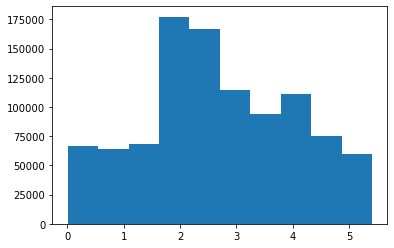

In [208]:
plt.hist(_simul.D[_simul.D>0])

In [209]:
_simul.get_weightmatrix(theta=(2.6888234729389295),kappa=2500) 

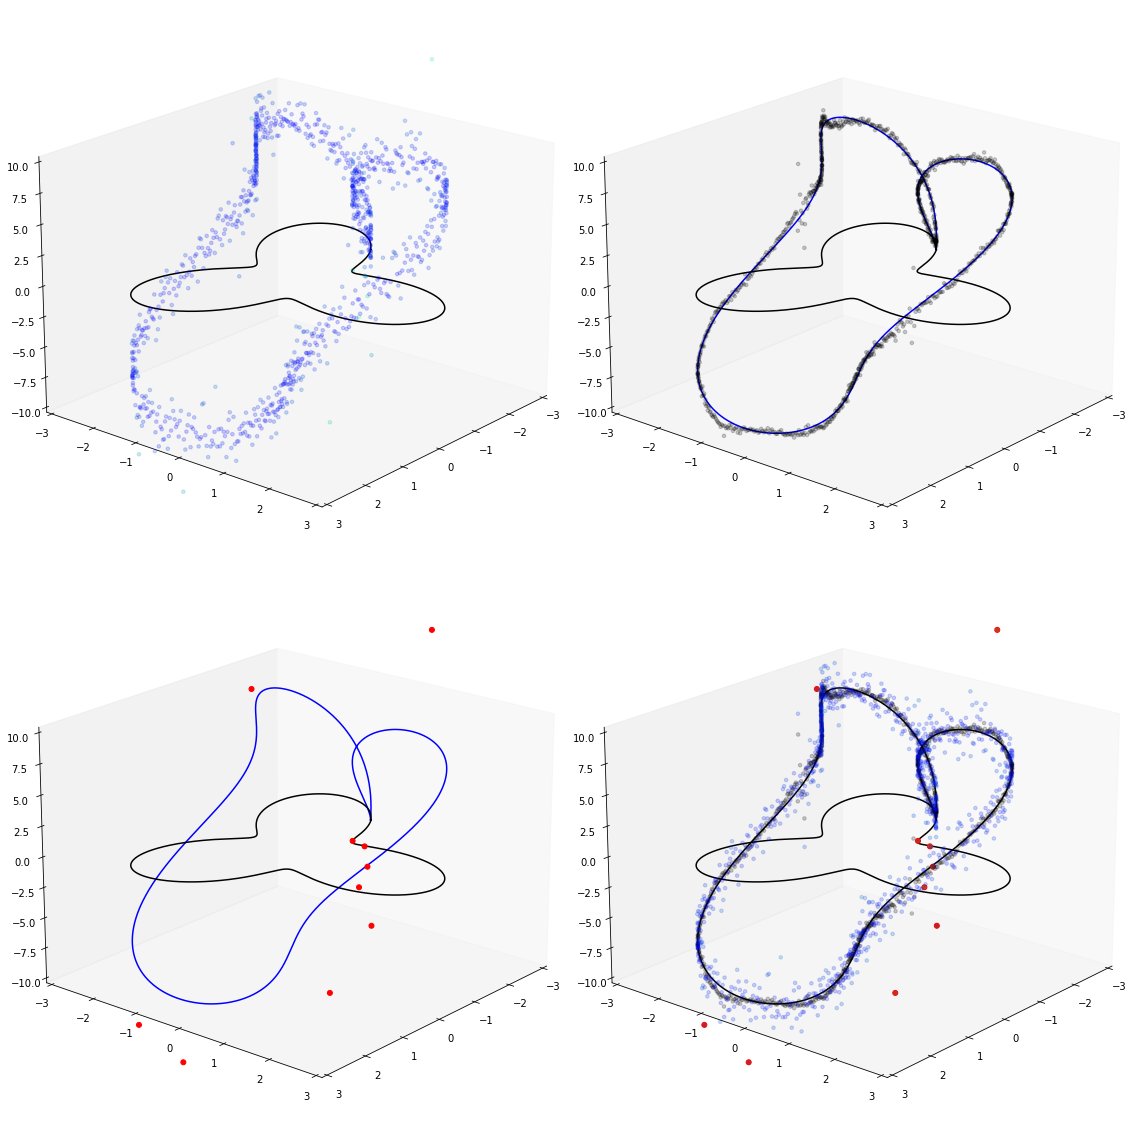

In [210]:
_simul.fit(sd=5,ref=20)

In [174]:
#_simul.vis(ref=20)

In [175]:
#_simul.subvis(ref=20)

In [125]:
#_simul.sub()

In [126]:
#_simul.subvis()

## 3D 시도 2

In [148]:
### Example 2
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,8*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,3*pi,n))
f = f1 + x

In [149]:
df1 = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})

In [150]:
_simul = SIMUL(df1)

In [151]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 549.85it/s]


In [152]:
_simul.D[_simul.D>0].mean()

2.6984753461932702

(array([ 63450.,  64118., 146970., 169756., 138202., 126198., 162650.,
         75642.,  28416.,  23598.]),
 array([0.0062838 , 0.60565122, 1.20501864, 1.80438605, 2.40375347,
        3.00312089, 3.6024883 , 4.20185572, 4.80122314, 5.40059055,
        5.99995797]),
 <BarContainer object of 10 artists>)

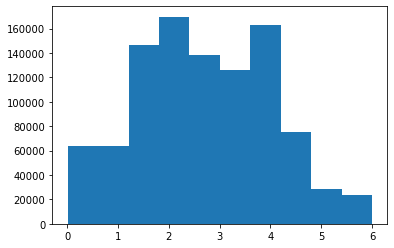

In [153]:
plt.hist(_simul.D[_simul.D>0])

In [154]:
_simul.get_weightmatrix(theta=(2.6984753461932702),kappa=2500) 

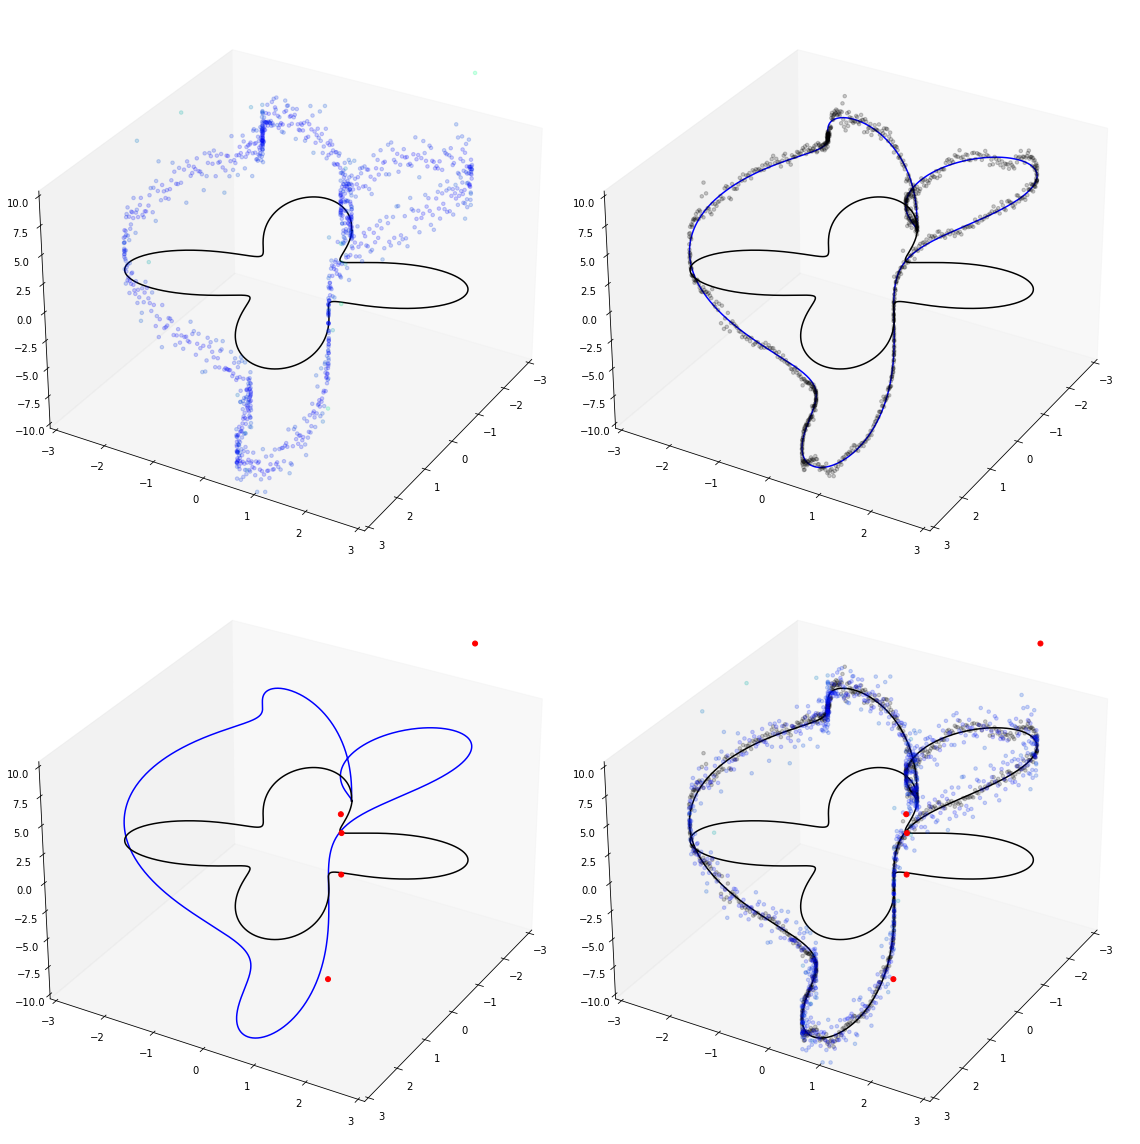

In [155]:
_simul.fit(sd=5,ref=30)

In [156]:
#_simul.vis(ref=50)

In [157]:
#_simul.sub()

In [71]:
#_simul.subvis()

## 3D 시도 3

In [158]:
### Example 2
np.random.seed(777)
pi=np.pi
n=1000
ang=np.linspace(-pi,pi-2*pi/n,n)
r=2+np.sin(np.linspace(0,6*pi,n))
vx=r*np.cos(ang)
vy=r*np.sin(ang)
f1=10*np.sin(np.linspace(0,6*pi,n))
f = f1 + x

In [159]:
df2 = pd.DataFrame({'x' : vx, 'y' : vy, 'f' : f,'f1':f1})

In [160]:
_simul = SIMUL(df2)

In [161]:
_simul.get_distance()

100%|██████████| 1000/1000 [00:01<00:00, 552.94it/s]


In [162]:
_simul.D[_simul.D>0].mean()

2.6888234729389295

(array([ 66308.,  64352.,  68358., 177302., 166964., 114648.,  94344.,
        111136.,  75508.,  60080.]),
 array([0.00628415, 0.54637775, 1.08647135, 1.62656495, 2.16665855,
        2.70675214, 3.24684574, 3.78693934, 4.32703294, 4.86712654,
        5.40722013]),
 <BarContainer object of 10 artists>)

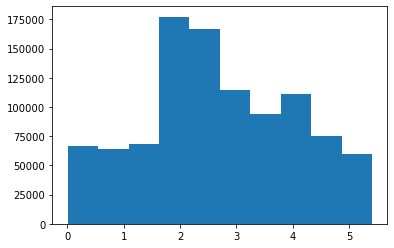

In [163]:
plt.hist(_simul.D[_simul.D>0])

In [164]:
_simul.get_weightmatrix(theta=(2.6984753461932702),kappa=2500) 

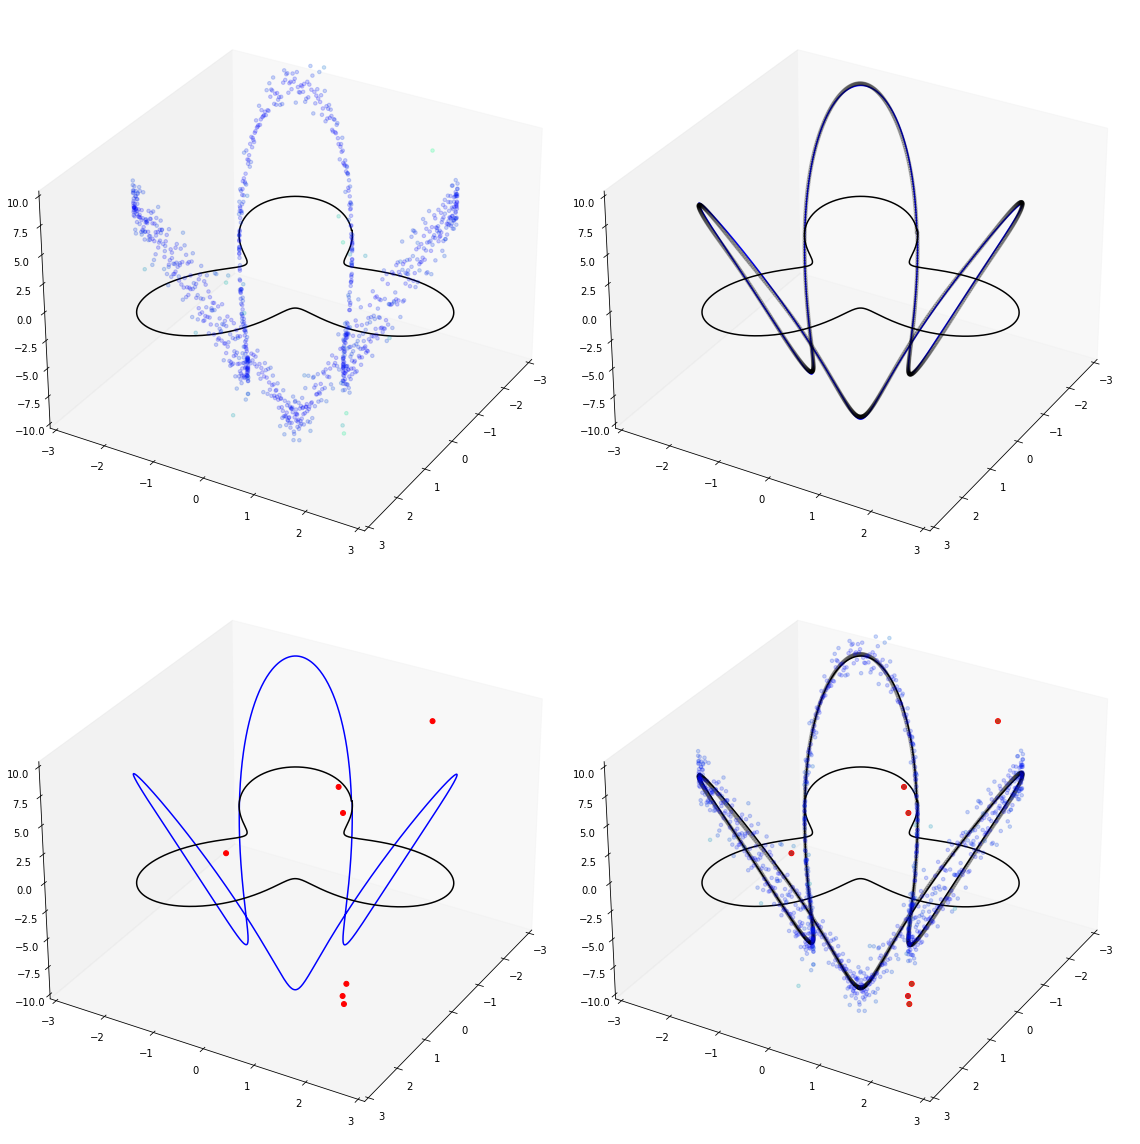

In [165]:
_simul.fit(sd=5,ref=30)

In [166]:
#_simul.vis(ref=50)

In [167]:
#_simul.sub()

In [82]:
#_simul.subvis()